# Classification for the centar of mass $(r_\text{cm})$ of exoplanetary systems through GMM 

We use Gaussian Mixture Model to clasify the center of mass of exoplanetary systems, employing the sinthetic data  

In [1]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [2]:
import pandas as pd; 
import numpy as np
from scipy.stats import norm, truncnorm
import random
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt 
import seaborn as sb
from matplotlib import rc, cm, rcParams
%matplotlib inline

plt.style.use('./data/img.mplstyle')

import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r"\usepackage{bm} \usepackage{amsmath}"

simulated data:

In [3]:
dn=pd.read_csv('data/proc_no_pert.csv',index_col=None)#, usecols = ["ms","md","metal","taugas","com",
dl=pd.read_csv('data/proc_lo_pert.csv',index_col=None)#, usecols = ["ms","md","metal","taugas","com",
dh=pd.read_csv('data/proc_hi_pert.csv',index_col=None)#, usecols = ["ms","md","metal","taugas","com",

In [4]:
dh.head()
#dh["com"].isna().sum()

,Unnamed: 0,ident,com,nplanets,massbudget,massefficiency,sigmag0,md,rc,ms,metal,taugas,qest,ngi,mtr,apert
0,0,3.0,0.528895,12.0,5818.115137,0.311685,90.793337,0.056,29.539343,0.880114,0.328146,1.644711e+06,8.421395,3.0,9.132650,0.3
1,1,5.0,2.406300,13.0,31.567339,0.000861,102.431593,0.110,38.977428,1.075269,-0.150160,1.014449e+06,5.464831,1.0,17.678581,0.3
2,2,6.0,1.082299,9.0,5886.747227,0.147169,75.740878,0.120,47.343380,0.861595,0.021273,1.790533e+06,4.412694,1.0,8.262408,0.3
3,3,8.0,7.503351,9.0,7.884462,0.000158,62.737337,0.150,58.158928,1.076658,-0.282408,6.017040e+06,4.704798,0.0,7.884462,0.3
4,4,13.0,5.247285,12.0,33.730980,0.000595,178.830700,0.170,36.672222,1.206445,-0.174039,3.956708e+06,3.998513,1.0,8.003117,0.3


Center of mass distributions by histograms 

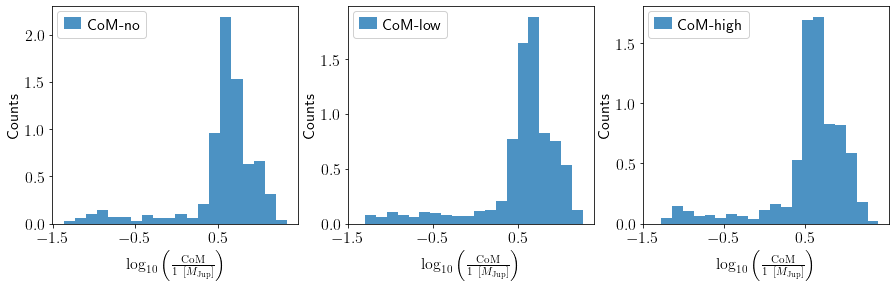

In [5]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

bins, size = 20, 16

ax1.hist(np.log10(dn["com"].values), bins = bins, alpha = .8, 
         density= True, label=r'CoM-no')
ax1.set_xticks(np.arange(int(min(np.log10(dn["com"].values)))-.5, 
                         int(max(np.log10(dn["com"].values)))+.5, 1.0))
ax1.set_xlabel(r"$\log_{10}\left(\frac{\mathrm{CoM}}{1\ [M_\mathrm{Jup}]}\right)$", fontsize=size)
ax1.set_ylabel(r"Counts", fontsize=size)
ax1.legend(handletextpad=.4, labelspacing=.25, loc=0, fontsize=size)
ax1.tick_params(axis='both', labelsize=size)


ax2.hist(np.log10(dl["com"].values), bins = bins, alpha = .8, 
         density= True, label=r'CoM-low')
ax2.set_xlabel(r"$\log_{10}\left(\frac{\mathrm{CoM}}{1\ [M_\mathrm{Jup}]}\right)$",fontsize=size)
ax2.set_xticks(np.arange(int(min(np.log10(dl["com"].values)))-.5, 
                         int(max(np.log10(dl["com"].values)))+.5, 1.0))
ax2.set_ylabel(r"Counts", fontsize =size)
ax2.legend(handletextpad=.4, labelspacing=.25, loc=0, fontsize=size)
ax2.tick_params(axis='both', labelsize=size)


ax3.hist(np.log10(dh["com"].values), bins = bins, alpha = .8, 
         density= True, label=r'CoM-high')
ax3.set_xlabel(r"$\log_{10}\left(\frac{\mathrm{CoM}}{1\ [M_\mathrm{Jup}]}\right)$", fontsize=size)
ax3.set_xticks(np.arange(int(min(np.log10(dh["com"].values)))-.5, 
                         int(max(np.log10(dh["com"].values)))+.5, 1.0))
ax3.set_ylabel(r"Counts", fontsize =size)
ax3.legend(handletextpad=.4, labelspacing=.25, loc=0, fontsize=size)
ax3.tick_params(axis='both', labelsize=size)

Comparing the plots

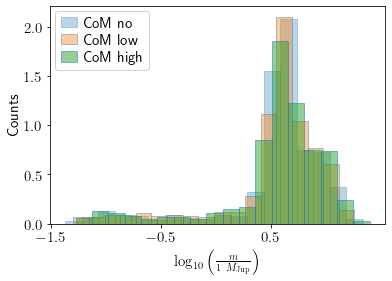

In [6]:
fig, (ax1) = plt.subplots(1, 1, figsize=(6, 4))
bins, size = 18, 15
names = ["no", "low", "high"]

CoM_log=[np.log10(dn["com"]), np.log10(dl["com"]), np.log10(dh["com"])]

for i in (range(len(CoM_log))):
    _, _, bars0 = ax1.hist(CoM_log[i], bins=bins, label=r'CoM '+names[i],
                           color = "C"+str(i), alpha = .3+(i/10), density= True)
    for bar0 in bars0:
        bar0.set_edgecolor("C0")

ax1.set_xlabel(r"$\log_{10}\left(\frac{m}{1\ M_\mathrm{Jup}}\right)$", fontsize=size)
ax1.set_xticks(np.arange(int(min(CoM_log[0]))-.5, int(max(CoM_log[0]))+.5, 1.0))
ax1.set_ylabel(r"Counts", fontsize=size)
ax1.tick_params(axis='both', labelsize=size)
ax1.legend(handletextpad=.4, labelspacing=.25, loc=0, fontsize=size)

A class to get the GMM and the ideal number of clusters.

In [7]:
class clustering(object): #It needs a column of a df with the center of mass
    
    def __init__(self, CoM, log):  
        
        if log==True:
            self.r_cm = np.log10(CoM.values).reshape(-1,1)
            self.name=r'$\log_{10}\frac{\mathrm{CoM}}{1\ \mathrm[AU]}$'
        else: 
            self.r_cm= self.com
            self.name=r'$\mathrm{CoM}$ [AU]'
            
    def GMM(self, n_components):
        self.n   = n_components
        self.gmm = GaussianMixture(n_components, covariance_type='full', random_state=0)
        self.gmm.fit(self.r_cm)
        self.cluster_label = self.gmm.predict(self.r_cm)
        
    def inf_criteria(self, times):
        self.bic, self.aic = [], []
        for i in range(times):
            i += 1
            self.GMM(i)
            self.bic.append(self.gmm.bic(self.r_cm)); self.aic.append(self.gmm.aic(self.r_cm))
        
        self.ideal = self.bic.index(min(self.bic))+1
        
        print('Ideal number of clusters, BIC = '+str(self.bic.index(min(self.bic))+1))
        print('Ideal number of clusters, AIC = '+str(self.aic.index(min(self.aic))+1))

In [8]:
def plot_criteria(criteria):
  
    figure, ax = plt.subplots(1, 2,figsize = (10,3.5))
    label = ['BIC','AIC']

    for i,criterium in enumerate(criteria):
        dim  = len(criteria[i])
        norm = min(criteria[i])/max(criteria[i])
        
     
        ax[i].plot(range(1, dim+1),criteria[i]/max(criteria[i]), lw = 1.5, zorder=1)#, label=label[i])
        ax[i].plot(range(1, dim+1),np.ones(dim)*norm, color = "C4", alpha = .8, 
                   ls = "--",label=r"Ideal clustering = "+str(criteria[i].index(min(criteria[i]))+1) )

        ax[i].scatter(range(1, dim+1), criteria[i]/max(criteria[i]), 
                     marker = "h", s = 20,c="C4",label=label[i]+" value", zorder=2)
        
        ax[i].set_xlabel(r'Number of clusters $k$')
        ax[i].set_ylabel(r'Normal value')
        
        ax[i].legend(loc=0)#,edgecolor='black')
        ax[i].set_xlim(0, dim+1)
        ax[i].set_xticks(np.arange(0, dim+1, step=2))
        #ax[i].tick_params()

    plt.subplots_adjust(wspace=0.4)
    #plt.savefig("figures/BIC-AIC.pdf",bbox_inches='tight')
    #return [bic,aic]

In [9]:
def clusters_plot2(data, groups, nbins = 60):
    
    cluster = clustering(data, True)
    cluster.GMM(groups)
    
    a = cluster.r_cm
    x = np.linspace(a.min(),a.max(),1000).reshape(-1,1)
    
    figure, ax = plt.subplots(1, 1); fig.tight_layout()
    ax.set(xlim=(x.min(),x.max()))
    rcm = ax.hist(a, bins=nbins, density = True, alpha = .5, label = r'$\log_{10}\left(\frac{r_\mathrm{cm}}{1\ \mathrm{AU}}\right)$')
    
    for c in range(cluster.n):
        g   = ax.plot(x, norm.pdf(x,cluster.gmm.means_[c], np.sqrt(cluster.gmm.covariances_[c]))/2,
                     label = "cluster"+str(c))#/\
                      #norm.pdf(x,cluster.gmm.means_[c], np.sqrt(cluster.gmm.covariances_[c])).max())
    
    plt.xlabel(r"$\log_{10}\left(\frac{r_\mathrm{cm}}{1\ \mathrm{[AU]}}\right)$")
    plt.ylabel(r"Counts")
    plt.legend()    

### GMM for no-perturbations case 

In [10]:
k = 20
clust_no = clustering(dn["com"], True)
clust_no.GMM(k)
clust_no.inf_criteria(k)

Ideal number of clusters, BIC = 4
Ideal number of clusters, AIC = 4


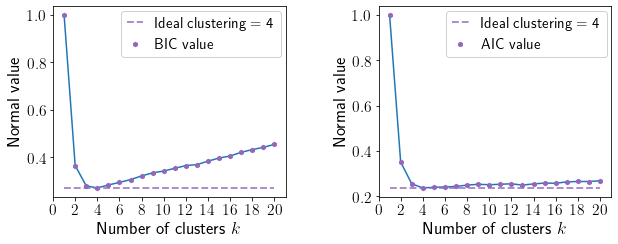

In [11]:
plot_criteria([clust_no.bic,clust_no.aic])

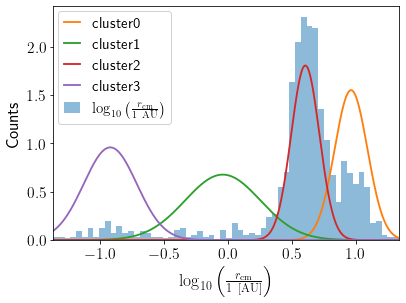

In [12]:
a = clusters_plot2(dn["com"],4)

### GMM for low perturbations case 

In [13]:
clust_low = clustering(dl["com"], True)
clust_low.GMM(k)
clust_low.inf_criteria(k)

Ideal number of clusters, BIC = 3
Ideal number of clusters, AIC = 6


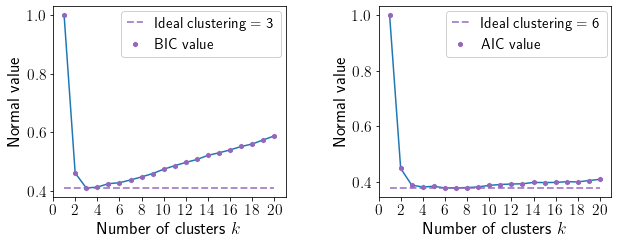

In [14]:
plot_criteria([clust_low.bic,clust_low.aic])

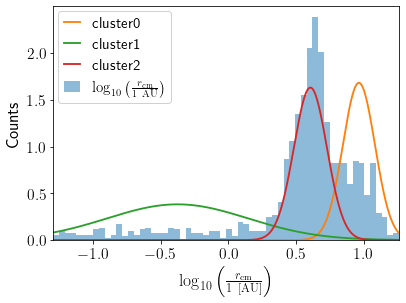

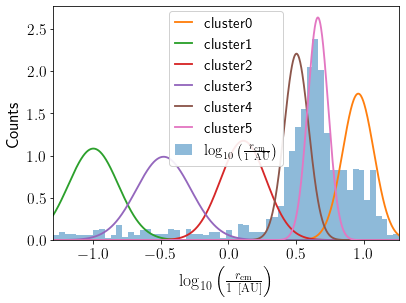

In [15]:
b = clusters_plot2(dl["com"],3)
c = clusters_plot2(dl["com"],6)

### GMM for high perturbations case 

In [16]:
clust_high = clustering(dl["com"], True)
clust_high.GMM(k)
clust_high.inf_criteria(k)

Ideal number of clusters, BIC = 3
Ideal number of clusters, AIC = 6


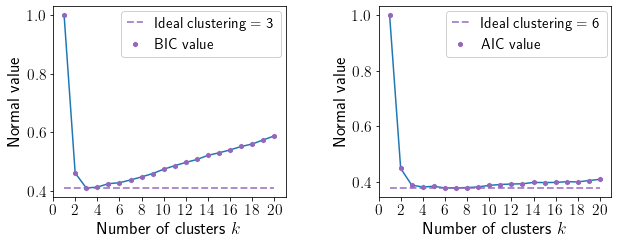

In [17]:
plot_criteria([clust_high.bic,clust_low.aic])

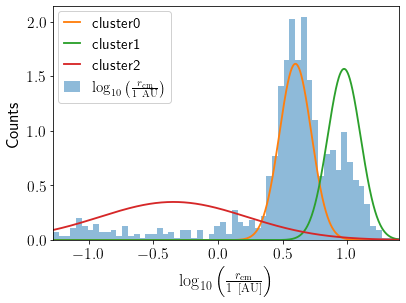

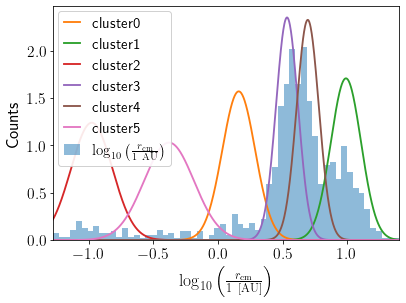

In [18]:
d = clusters_plot2(dh["com"],3)
e = clusters_plot2(dh["com"],6)

### Sensitivity

In [19]:
class draw(clustering):
    
    def __init__(self, data, log):
        clustering.__init__(self, data, log)
    
    def draws(self):
        
        self.Draws = [] # a 1000 synthetic r_cm for each system
        self.mus, self.ass, self.au = [], [], []
        for sistem in self.p_system.groups.keys():
            
            self.SystemA_i = data[data.star_name == sistem]  
            #print(self.SystemA_i.star_name.values) 
            
            Mass_System, Mass_Axe  = [],[]#, np.zeros(1000)
            
            mu_m, mu_a = [],[]
            sigma_m, sigma_a = [],[]
            
            
            for planet in range(len(self.SystemA_i)):
                    
                mu_m = self.SystemA_i.mass.values[planet]
                sigma_m = self.SystemA_i.mass_error_min.values[planet]
                
                mu_a    = self.SystemA_i.semi_major_axis.values[planet]
                sigma_a = self.SystemA_i.semi_major_axis_error_min.values[planet]
                
                lower_m = 0
                upper_m = mu_m+3*sigma_m 
                
                lower_a = 0 
                upper_a = mu_a+3*sigma_a
                
                a_m = (lower_m - mu_m)/sigma_m
                b_m = (upper_m - mu_m)/sigma_m
                
                a_a = (lower_a - mu_a)/sigma_a #valores muy raros
                b_a = (upper_a - mu_a)/sigma_a
            
                masses = truncnorm.rvs(a_m, b_m, scale=sigma_m, loc=mu_m, size=1000)
                axes   = truncnorm.rvs(a_a, b_a, scale=sigma_a, loc=mu_a, size=1000)
            
                Mass_Axe.append(masses*axes)
                Mass_System.append(masses)

            M_A = np.array(Mass_Axe).sum(axis=0)
            M   = np.array(Mass_System).sum(axis = 0)
        
            self.Draws.append(M_A/M)
        
    def fraction_ch(self, drawss, r = 15):
        r = 10
        frac=[]
        #self.draws()
        self.inf_criteria(r)
        self.GMM(self.ideal)
        
        if self.log == True:  
            Dr = np.log10(drawss)
            
        for k in range(len(Dr)):
            Draw_i=Dr[k][:,np.newaxis]
            frac+=[(self.cluster_label[k]!=self.gmm.predict(Draw_i)).sum()/len(Dr)] # AA es el elemento i de draws (que debe ser un array de 1000 elementos)
            p = sum(frac)/len(frac)*100
            
        return print("the change is "+str('%.2f' % p)+r"\%")


In [20]:
import session_info
session_info.show()

ModuleNotFoundError: No module named 'session_info'

In [ ]:
import session_info
